### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read slimmed PKU Tree files to plot pre-fit results

env:HWW


### Import necessary modules

In [17]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
# from sklearn.metrics import roc_curve, auc
from cycler import cycler
import uproot
# means uproot4
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings

import hist as hist2
import pyarrow
# import utils #local file: utils.py
import yaml
from typing import Dict, List, Union
from dataclasses import dataclass
from copy import deepcopy

# from coffea import hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector
# from coffea.nanoevents.methods.vector import PtEtaPhiMLorentzVector

### Read SlimmedTree files

In [18]:
MODE = "slimmedtree"
# year = "2016"
# year = "2017"
# year = "2018"
year = "Full-Run2"
if MODE == "slimmedtree_validation":
    CustNanoData = {
        'data'        : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Data/SlimmedTree_Data.root"%(year),
        'QCD'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/MC/SlimmedTree_QCD.root"%(year),          
        'WJets'       : "/data/bond/zhaoyz/SlimmedTree/V5/%s/MC/SlimmedTree_WJets.root"%(year),
        'Rest'        : "/data/bond/zhaoyz/SlimmedTree/V5/%s/ttbar_validation_final/Slimmed_Rest_ST.root"%(year),
        'TotalSignal' : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_Total.root"%(year),
        'ggF'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_GluGlu.root"%(year),
        'VH'          : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_VH.root"%(year),
        'ttH'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_ttH.root"%(year),
        'VBF'         : "/data/bond/zhaoyz/SlimmedTree/V5/%s/Signal/SlimmedTree_VBF.root"%(year),
        'ttbar_val'   : "/data/bond/zhaoyz/SlimmedTree/V5/%s/ttbar_validation_final/Slimmed_ttbar_validation.root"%(year),
    }
elif MODE == "tree_validation":
        CustNanoData = {
        'data'        : "/data/bond/zhaoyz/Tree/V8/%s/Merged/Data/Tree_Data.root"%(year),
        'QCD'         : "/data/bond/zhaoyz/Tree/V8/%s/Merged/MC/Tree_QCD.root"%(year),          
        'WJets'       : "/data/bond/zhaoyz/Tree/V8/%s/Merged/MC/Tree_WJets.root"%(year),
        'Rest'        : "/data/bond/zhaoyz/Tree/V8/%s/Merged/ttbar_validation_final/Rest_ST.root"%(year),
        'TotalSignal' : "/data/bond/zhaoyz/Tree/V8/%s/Merged/Signal/Tree_Total.root"%(year),
        'ggF'         : "/data/bond/zhaoyz/Tree/V8/%s/Merged/Signal/Tree_GluGlu.root"%(year),
        'VH'          : "/data/bond/zhaoyz/Tree/V8/%s/Merged/Signal/Tree_VH.root"%(year),
        'ttH'         : "/data/bond/zhaoyz/Tree/V8/%s/Merged/Signal/Tree_ttH.root"%(year),
        'VBF'         : "/data/bond/zhaoyz/Tree/V8/%s/Merged/Signal/Tree_VBF.root"%(year),
        'ttbar_val'   : "/data/bond/zhaoyz/Tree/V8/%s/Merged/ttbar_validation_final/ttbar_validation.root"%(year),
    }
else:
    CustNanoData = {
        'data'        : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/Data/SlimmedTree_Data.root",
        'QCD'         : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_QCD.root",          
        'Top'         : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_Top.root",
        'WJets'       : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_WJets.root",
        'Rest'        : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/MC/SlimmedTree_Rest.root",
        'TotalSignal' : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_Total.root",
        'ggF'         : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_GluGlu.root",
        'VH'          : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_VH.root",   
        'ttH'         : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_ttH.root",
        'VBF'         : "/data/bond/zhaoyz/SlimmedTree/V5/Full-Run2/Signal/SlimmedTree_VBF.root",
    }    
BKG = ["QCD","Top","WJets","Rest"]
files = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" })


#for deco
files[r"$H^{4q}$"] = files["TotalSignal"][files["TotalSignal"]["R4q_a"] == 1]
files[r"$H^{3q}$"] = files["TotalSignal"][(files["TotalSignal"]["R3q_a"] == 1) & (files["TotalSignal"]["R3q_taudecay_a"] != 1)]
files["W"] = files["TotalSignal"][files["TotalSignal"]["w_a"] == 1]
files["top"] = files["TotalSignal"][files["TotalSignal"]["t_a"] == 1]
files["Z"] = files["TotalSignal"][files["TotalSignal"]["z_a"] == 1]
files[r"$H^{lqq}$"] = files["TotalSignal"][(files["TotalSignal"]["Rlqq_a"] == 1) | (files["TotalSignal"]["R3q_taudecay_a"] == 1)]
files["g/q"] = files["TotalSignal"][files["TotalSignal"]["gKK_g_a"] == 1]
files["rest"] = files["TotalSignal"][(files["TotalSignal"]["u_a"] == 1) | (files["TotalSignal"]["Rlq_a"] == 1) | (files["TotalSignal"]["R2q_a"] == 1)]


### Get DPhi in the events

In [19]:
def get_dphi(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    delta_phi = np.subtract(vec_MET.phi, vec_higgs.phi)
    delta_phi = np.where(delta_phi > np.pi, delta_phi - 2*np.pi, delta_phi)
    delta_phi = np.where(delta_phi < -np.pi, delta_phi + 2*np.pi, delta_phi)
    delta_phi = np.abs(delta_phi)
    print(delta_phi)
    events["DPhi"] = delta_phi

for k in files:
    print("Add dphi of:",k)
    get_dphi(events=files[k])

Add dphi of: data
[0.597, 0.363, 0.458, 1.07, 2.84, 0.341, ... 0.767, 0.2, 0.504, 3.03, 0.289, 0.0353]
Add dphi of: QCD
[2.8, 2.58, 0.514, 2.3, 3.01, 0.305, 0.629, ... 0.0396, 3.07, 0.765, 3, 2.96, 3.07]
Add dphi of: Top
[0.377, 0.707, 0.49, 2.48, 2.35, 2.75, 2.95, ... 0.169, 2.6, 2.94, 1.61, 1.35, 3.05]
Add dphi of: WJets
[2.81, 0.123, 1.6, 0.0544, 2.76, 2.51, ... 2.74, 0.508, 2.42, 1.41, 2.56, 0.258]
Add dphi of: Rest
[2.56, 1.73, 0.401, 3.13, 3.03, 2.83, 1.66, ... 1.26, 1.24, 0.0949, 2.46, 1.87, 2.91]
Add dphi of: TotalSignal
[2.4, 1.87, 3.06, 3.04, 2.91, 1.51, 2.08, ... 3.1, 0.141, 0.273, 0.498, 1.18, 2.73]
Add dphi of: ggF
[2.4, 1.87, 3.06, 3.04, 2.91, 1.51, 2.08, ... 3.09, 0.722, 3, 3.11, 3.07, 0.455]
Add dphi of: VH
[0.168, 1.39, 2.76, 1.26, 0.0118, 2.83, ... 3.1, 0.141, 0.273, 0.498, 1.18, 2.73]
Add dphi of: ttH
[3.12, 2.62, 2.28, 2.03, 0.0168, 0.16, ... 0.743, 0.839, 2.31, 2.44, 2.99, 0.506]
Add dphi of: VBF
[2.97, 2.31, 0.0849, 0.17, 0.0194, 0.481, ... 1.13, 0.332, 2.5, 2.82,

In [20]:

def get_reco(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_sum = vec_MET + vec_higgs
    mH_reco = vec_sum.mass
    events["MH_Reco"] = ak.where(( (events["DPhi"] < 0.8) & (events["MET_et"]/events["PTj_V2_a"] > 0.1)),mH_reco, events["Mj_V2_a"])


In [21]:
for k in files:
    print("Add reco of:",k)
    get_reco(events=files[k])

Add reco of: data
Add reco of: QCD
Add reco of: Top
Add reco of: WJets
Add reco of: Rest
Add reco of: TotalSignal
Add reco of: ggF
Add reco of: VH
Add reco of: ttH
Add reco of: VBF
Add reco of: $H^{4q}$
Add reco of: $H^{3q}$
Add reco of: W
Add reco of: top
Add reco of: Z
Add reco of: $H^{lqq}$
Add reco of: g/q
Add reco of: rest


### some test about variables

In [22]:
files["VBF"].fields

['PTj_min',
 'Etaj_min',
 'R4q_a',
 'Phij',
 'a_Htauhtauh',
 'Mj_corr',
 'nb_t_deep_in',
 'Etaj_2',
 'R4q_c',
 'a_TopbWtauhv',
 'R3q_taudecay_b',
 'Mj_corr_a',
 'a_TopbWtauev',
 'w_a',
 'MET_et',
 'a_HWqqWtauhv0c',
 'a_QCDbb',
 'Etaj_V2_c',
 'Phij_mid',
 'R2q_a',
 'a_HWqqWtaumv0c',
 'a_Hbb',
 'Etaj_V2_a',
 'a_QCDc',
 'MJJ',
 'gKK_g_c',
 'Mj_mid',
 'PTj',
 'SF',
 'Mj_V2_b',
 'Rlqq_c',
 'Phij_max',
 'a_TopbWqq1c',
 'a_Hss',
 'a_HWqqWqq0c',
 'a_HWqqWmv1c',
 'MJJJ',
 'R2q_b',
 'a_HWW_V2',
 'PTj_V2_a',
 'nb_t_deep_ex',
 'a_HWqqWtaumv1c',
 'R2q_c',
 'PTj_3',
 'Etaj_V2_b',
 'R3q_c',
 'a_Htauhtaum',
 'Mj_corr_2',
 'ST',
 'Etaj_3',
 'Etaj_max',
 'Mj_min',
 'MET_T1Smear_phi_XYcorr',
 'PTj_2',
 'a_HWqqWq1c',
 'Rlq_b',
 'z_a',
 'Nj4_in',
 'a_HWqqWtauev1c',
 'Mj_V2_a',
 'Mj_corr_c',
 'Etaj_mid',
 'a_TopbWqq0c',
 'a_HWqqWmv0c',
 'Phij_V2_b',
 'Phij_min',
 'Phij_2',
 'nb_m_deep_ex',
 'Mj_max',
 'R4q_b',
 'weight',
 'Mj',
 't_c',
 'Phij_V2_a',
 'a_QCDb',
 'a_Hqq',
 'b_HWWvsQCD_V2',
 'nb_l_deep_in',
 '

### plot setting

In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=True):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side


### prepare prefit QCD distribution for CR and SR respectively

In [24]:
def store_root(file_name, dir_name, hist_name, bin_edges, bin_contents, bin_errors, rewrite = False, verbose = False):
    if os.path.exists(file_name):
        if verbose: print(f"The file '{file_name}' already exists.")
        if not rewrite:
            if verbose:print("Will update it.")
            output_file = ROOT.TFile(file_name, "update")
        else: 
            if verbose:print("Will recreate one.")
            output_file = ROOT.TFile(file_name, "recreate")
    else:
        if verbose:print(f"The file '{file_name}' does not exist, will create a new one")
        output_file = ROOT.TFile(file_name, "recreate")
    if output_file.GetDirectory(dir_name):
        if verbose:print("The " + dir_name + " directory exists in the ROOT file, use the existing one")
        output_file.cd(dir_name)
    else:
        if verbose:print("The " + dir_name + " directory does not exist in the ROOT file, create a new one")
        output_file.mkdir(dir_name)
        output_file.cd(dir_name)
    histogram = ROOT.TH1D(hist_name, "Histogram 1", len(bin_edges) - 1, bin_edges)
    for i, content in enumerate(bin_contents):
        histogram.SetBinContent(i + 1, content)
        histogram.SetBinError(i + 1, bin_errors[i]) 
    histogram.Write()
    output_file.Close()
    

    # Return the updated histogram and variance

#Function that plot mass distribution, with different tagger cut in the same plot.

def plot_mass_shape_store_blinded(files, nbins=20, x_min=50, x_max=250, legend_location='upper left',suffix = ""):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    plt.figure(figsize=(9,9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=False, year="Full-Run2", ax=ax, fontname='sans-serif')
    def flow(hist: bh.Histogram, overflow: bool=False, underflow: bool=False):
        h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
        if overflow: 
            # h, var also include underflow bins but in plots usually no underflow data
            # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
            # You have to access the overflow and underflow bins data like below:
            h[-2] += h[-1]; var[-2] += var[-1]
        if underflow:
            h[1] += h[0]; var[1] += var[0]
        if overflow or underflow:
            h, var = h[1:-1], var[1:-1]
        return np.array([h, var])
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.99))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.99) & (events["DPhi"] < 0.8))
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99) & (events["DPhi"] < 0.8))
        else: print("invalid SR value")
        return maskdict_sr
    def maskdict_cr(files_i, CR):
        events = files_i
        if   CR == "SR1a" or CR == "SR1b": maskdict_cr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] < 0.92)), 
        elif CR == "SR2a" or CR == "SR2b": maskdict_cr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] < 0.92) & (events["DPhi"] < 0.8)),         
        else: print("invalid CR value")
        return maskdict_cr
    for met in ["SR1","SR2"]:
        #we store just 1 root files 
        rest = ["Top","WJets","Rest"]
        events_rest_tmp = ak.concatenate([files[i] for i in rest], axis=0)
        hist_cr_QCD =   bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_cr_Data = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_cr_Rest = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        events_cr_QCD     = files["QCD"][maskdict_cr(files["QCD"],met + "a")]
        events_cr_Data    = files["data"][maskdict_cr(files["data"],met + "a")]
        events_cr_Rest    = events_rest_tmp[maskdict_cr(events_rest_tmp,met + "a")]
        hist_cr_QCD.fill(events_cr_QCD["MH_Reco"],    weight = events_cr_QCD["weight"]) #only used to calculate CR QCD yields
        hist_cr_Data.fill(events_cr_Data["MH_Reco"],  weight = events_cr_Data["weight"])
        hist_cr_Rest.fill(events_cr_Rest["MH_Reco"],  weight = events_cr_Rest["weight"])
        bins = hist_cr_QCD.axes[0].edges
        yields_cr_QCD = np.sum(flow(hist_cr_QCD)[0]) # to include overflow
        # hist_cr_QCD_value    = flow(hist_cr_QCD)[0] # not used at all 
        hist_cr_Data_value   = flow(hist_cr_Data)[0]
        hist_cr_Rest_value   = flow(hist_cr_Rest)[0] 
        # hist_err_cr_QCD_value    = np.sqrt(flow(hist_cr_QCD)[1]) #not used at all
        hist_err_cr_Data_value   = np.sqrt(flow(hist_cr_Data)[1])
        hist_err_cr_Rest_value   = np.sqrt(flow(hist_cr_Rest)[1])
        # print("hist value and variance done.")                          
        hist_Data_Rest_value = hist_cr_Data_value - hist_cr_Rest_value
        hist_err_Data_Rest_value = np.sqrt((hist_err_cr_Data_value)**2 + (hist_err_cr_Rest_value)**2 )  
        hep.histplot(hist_Data_Rest_value,     bins=bins, yerr=hist_err_Data_Rest_value, label= met.replace("S","C") + " estimated QCD(pre-fit)", lw = 2,edges = True, histtype="step") #,color = "red")
        if met == "SR1" : store_root("./root/perfit_QCD.root","QCD", met.replace("S","C"),  bin_edges = bins, bin_contents = hist_Data_Rest_value, bin_errors = hist_err_Data_Rest_value, rewrite=True)
        else: store_root("./root/perfit_QCD.root","QCD", met.replace("S","C"),  bin_edges = bins, bin_contents = hist_Data_Rest_value, bin_errors = hist_err_Data_Rest_value, rewrite=False)              
        print("finish ", met.replace("S","C"))
        for region in ["a","b"]:
            hist_sr_QCD =   bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
            events_cr_QCD     = files["QCD"][maskdict_sr(files["QCD"],met+region)]
            hist_sr_QCD.fill(events_cr_QCD["MH_Reco"],    weight = events_cr_QCD["weight"]) #also only used for SR QCD yields
            yields_sr_QCD = np.sum(flow(hist_sr_QCD)[0]) 
            mc_ratio = yields_sr_QCD/yields_cr_QCD
            hist_value = mc_ratio * hist_Data_Rest_value #means hist value in SR, using mc_ratio * hist_Data_Rest_value in CR QCD
            hist_err_value = mc_ratio * hist_err_Data_Rest_value
            hep.histplot(hist_value,     bins=bins, yerr=hist_err_value, label= met + region + " estimated QCD(pre-ft)", lw = 2,edges = True, histtype="step") #,color = "red")      
            store_root("./root/perfit_QCD.root","QCD",met+ region ,bin_edges = bins, bin_contents = hist_value, bin_errors = hist_err_value, rewrite=False)
            print("finish ",met + region)              
    # plt.ylim(0, 1e9)
    plt.xlabel("Higgs candidate MET-reco. mass", fontsize=20, ha='right', x=1)
    plt.ylabel("Events.", fontsize=20, ha='right', y=1)
    plt.xticks(size=14)
    plt.yticks(size=14)
    ax.set_yscale('log')
    ax.set_ylim(bottom = 1, top = 1e9)
    path_str = "./plots/prefit/"
    if not os.path.exists(path_str):
        os.makedirs(path_str)
    plt.legend(loc=legend_location,frameon=False,fontsize=12)
    plt.savefig(path_str + f"prefitmass_distri_prefit_QCD_2901_{suffix}.pdf", bbox_inches='tight')
    plt.show()

finish  CR1
finish  SR1a
finish  SR1b
finish  CR2
finish  SR2a
finish  SR2b


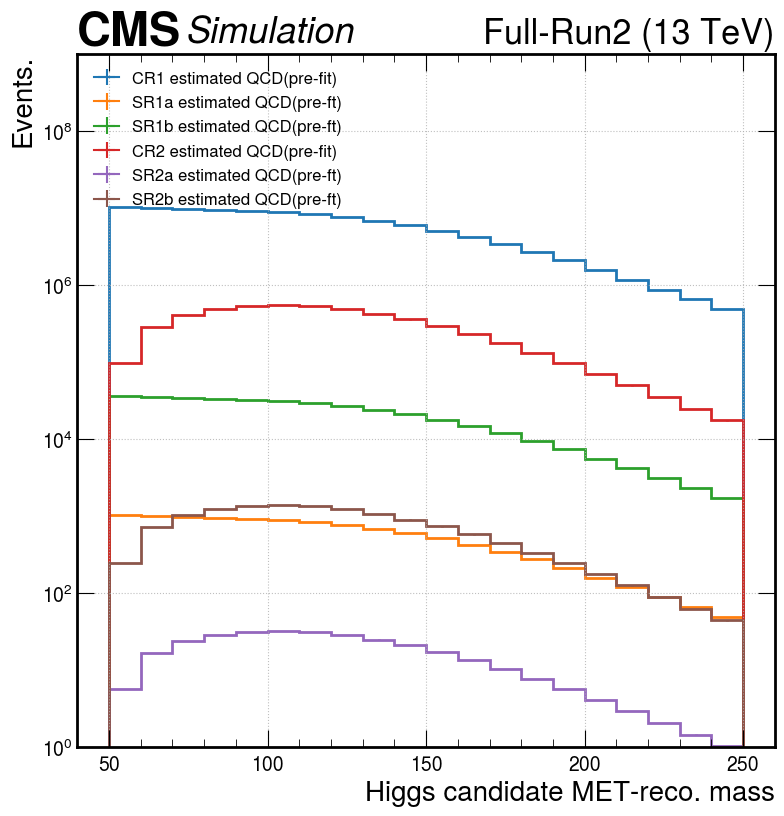

In [25]:
plot_mass_shape_store_blinded(files = files,nbins = 20, x_min=50, x_max=250,suffix = "")

### read the files just stored

In [26]:
def read_root(filename = "/home/pku/zhaoyz/Higgs/MDStudy/SR1a_Shape.root", dir = "QCD", name = "SRa"):
    ''' 
    filename:path/to/root
    dir:"QCD"
    name:region from ["CR1",...]
    '''
    with uproot.open(filename) as file:
        hist = file.get(dir + "/" + name)
        h = np.array(hist.values())
        var = np.array(hist.variances())        
    return h, var
    # here we defined a simple function to read the predicted QCD,etc. shapes from root file directly
    # but you have to be sure with the accuracy about the root file


### Plot variables

In [27]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def prefit_plot(arrays, weight, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = False, blindMC = False, nametext = "",optimal_cut = True, deco = False):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/bins
    if blind:
        mask = np.logical_or(arrays["data"] <= 90, arrays["data"] >= 150)
        arrays["data"] = arrays["data"][mask]
        if blindMC:
            maskQCD = np.logical_or(arrays["QCD"] <= 80, arrays["QCD"] >= 160)
            maskTop = np.logical_or(arrays["Top"] <= 80, arrays["Top"] >= 160)
            maskWJets = np.logical_or(arrays["WJets"] <= 80, arrays["WJets"] >= 160)
            maskRest = np.logical_or(arrays["Rest"] <= 80, arrays["Rest"] >= 160)
            maskTotalSignal = np.logical_or(arrays["TotalSignal"] <= 80, arrays["TotalSignal"] >= 160)
            maskggF = np.logical_or(arrays["ggF"] <= 80, arrays["ggF"] >= 160)
            maskVH = np.logical_or(arrays["VH"] <= 80, arrays["VH"] >= 160)
            maskttH = np.logical_or(arrays["ttH"] <= 80, arrays["ttH"] >= 160)
            maskVBF = np.logical_or(arrays["VBF"] <= 80, arrays["VBF"] >= 160)
            
            arrays["QCD"] = arrays["QCD"][maskQCD]
            arrays["Top"] = arrays["Top"][maskTop]
            arrays["WJets"] = arrays["WJets"][maskWJets]
            arrays["Rest"] = arrays["Rest"][maskRest]
            arrays["TotalSignal"] = arrays["TotalSignal"][maskTotalSignal]
            arrays["ggF"] = arrays["ggF"][maskggF]
            arrays["VH"] = arrays["VH"][maskVH]
            arrays["ttH"] = arrays["ttH"][maskttH]
            arrays["VBF"] = arrays["VBF"][maskVBF]
            
            weight["QCD"] = weight["QCD"][maskQCD]
            weight["Top"] = weight["Top"][maskTop]
            weight["WJets"] = weight["WJets"][maskWJets]
            weight["Rest"] = weight["Rest"][maskRest]
            weight["TotalSignal"] = weight["TotalSignal"][maskTotalSignal]
            weight["ggF"] = weight["ggF"][maskggF]
            weight["VH"] = weight["VH"][maskVH]
            weight["ttH"] = weight["ttH"][maskttH]
            weight["VBF"] = weight["VBF"][maskVBF]    
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","Top","WJets","Rest"]
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        # here the var are just usual standard variance
        if k in BKG: 
            if k == "QCD":   
                # read from root:  
                stacked['h'][k] , stacked['var'][k]  = read_root(filename = "./root/perfit_QCD.root", dir = "QCD", name = region)
                # no root is used here:
                # stacked['h'][k] = h
                # stacked['var'][k] = var
            else:             # other background
                stacked['h'][k] = h
                stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black',"ggF":"pink","VH":"blue","ttH":"yellow","VBF":"aqua"}
    SIG_DECO_COLOR = {'TotalSignal': 'black',r"$H^{4q}$":"green",r"$H^{3q}$":"orange","W":"blue","top":"purple","Z":"yellow",r"$H^{lqq}$":"cyan","g/q":"pink","rest":"gray"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","Top","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        colors = ["#1f77b4", "#ff7f0e", "#2ca02c","#d62728"]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list, yerr = err_list, histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        bkg_err = np.sum(err_list ,  axis=0)
        bin_edges = np.linspace(x_min, x_max, bins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001)
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        if k=='data': #data
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_error, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
        else:  # signal
            if deco != True:
                if k in ["TotalSignal","ggF","VH","ttH","VBF"]:
                    err = error_bar(h, individual['var'][k], type='mc')
                    hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            else: #deco mode
                # suffix += "DECO"
                if k not in ["ggF","VH","ttH","VBF"]:
                    frac = "(" + "%.1f"%(np.sum(h)/np.sum(individual['h']["TotalSignal"])*100)+ "%)"
                    err = error_bar(h, individual['var'][k], type='mc')
                    if k != "TotalSignal": hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+frac, histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    else:hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_DECO_COLOR[k])
            if k == "TotalSignal":
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal two-side cut =",best_lower, best_upper, best_s_sqrt_b)
                best_cut, best_s_sqrt_b = optimalcut_oneside(h,bkg_h)
                print("Optimal one-side cut =",best_cut, best_s_sqrt_b) 
                best_cut, best_combined_sig_two_side = optimalcut_mid_combine(individual['h'][r"$H^{4q}$"],individual['h'][r"$H^{lqq}$"],bkg_h)
                print("Optimal mid-side cut = ",best_cut,best_combined_sig_two_side)
            if optimal_cut == True:
                cut_value_low = x_min + best_lower * (x_max - x_min)/bins
                ax2.axvline(x=cut_value_low, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_low, ax2.get_ylim()[1]), xytext=(cut_value_low - (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                cut_value_up = x_min + best_upper * (x_max - x_min)/bins
                ax2.axvline(x=cut_value_up, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_up, ax2.get_ylim()[1]), xytext=(cut_value_up + (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                if cut_value_low < (x_max - cut_value_up):
                    text_position = cut_value_up + (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='left',fontsize = 13)
                else: 
                    text_position = cut_value_low - (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='right',fontsize = 13)

    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_yscale('log')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1e1)
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.4)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region + " " + othertext + " blinded",fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region + othertext + " Data/MC = " + str(round(data_mc_ratio,3)),fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=13)
    suffix = '_AU' if density else ''
    if deco: suffix += "_DECO"
    path_str = './plots/prefit/29Jan2024'
    if not os.path.exists(path_str):
        os.makedirs(path_str)
    plt.savefig(f"{path_str}/{year}_{plot_name}{suffix}_{region}{othertext}_{nametext}.pdf", bbox_inches='tight')
    plt.show()

In [28]:
CUT = {        
    "SR1a" : {k:  (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] >= 0.99) for k in files}, 
    "SR1b" : {k:  (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] >= 0.92) & (files[k]["a_HWW_V2"] < 0.99) for k in files},   
    "SR2a" : {k:  (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25) & (files[k]["a_HWW_V2"] >= 0.99) & (files[k]["DPhi"] < 0.8)for k in files}, 
    "SR2b" : {k:  (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25) & (files[k]["a_HWW_V2"] >= 0.92) & (files[k]["a_HWW_V2"] < 0.99) & (files[k]["DPhi"] < 0.8)for k in files},   
    "CR1"  : {k:  (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] <= 0.25) & (files[k]["a_HWW_V2"] < 0.92) for k in files},
    "CR2"  : {k:  (files[k]["MH_Reco"] >= 50) & (files[k]["MET_et"]/files[k]["PTj_V2_a"] > 0.25)  & (files[k]["a_HWW_V2"] < 0.92) & (files[k]["DPhi"] < 0.8) for k in files},   
    }

# CR: < 0.92

In [29]:
def prefit_runPlots(region = "PS", events = files,nametext = "", blind = False, othertext = ""):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events}   
    prefit_plot(arrays = {k: events[k][CUT[region][k]]["MH_Reco"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='MH_Reco', x_name=r'$jet_{a}:MET-recovery\, Mass$', x_max=250, x_min=50, bins=20, weight =weight, year="Full-Run2",blind = blind, blindMC = False,deco = True)

Should scale signal *  311.73475923134026
Optimal two-side cut = 3 11 0.40126455619009554
Optimal one-side cut = 3 0.3797852849962081
Optimal mid-side cut =  2 0.23485500585472446


/tmp/ipykernel_910750/2383463486.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_910750/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_910750/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_910750/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_910750/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_910750/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_910750/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_910750/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_910750/314159992.p

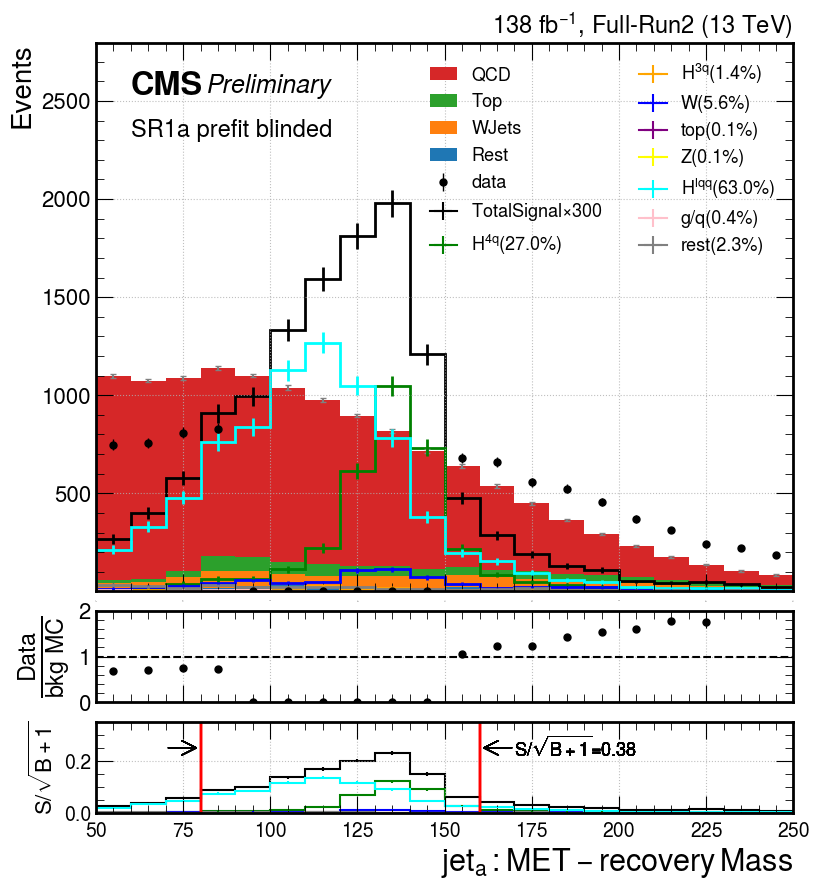

Should scale signal *  2811.9790172400412
Optimal two-side cut = 6 11 0.26384468663027766
Optimal one-side cut = 5 0.2508606274753578
Optimal mid-side cut =  12 0.13206666898300237


/tmp/ipykernel_910750/2383463486.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))


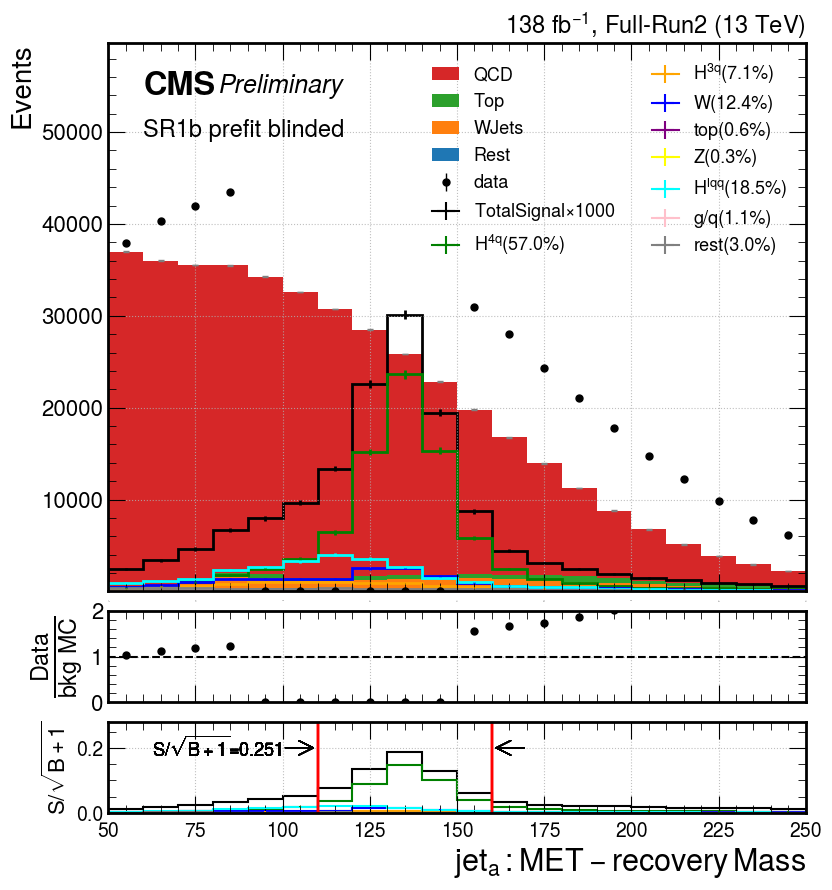

Should scale signal *  124048.83598706998
Optimal two-side cut = 2 20 0.08650363205507089
Optimal one-side cut = 2 0.08650363252859967
Optimal mid-side cut =  19 0.026832699951276736


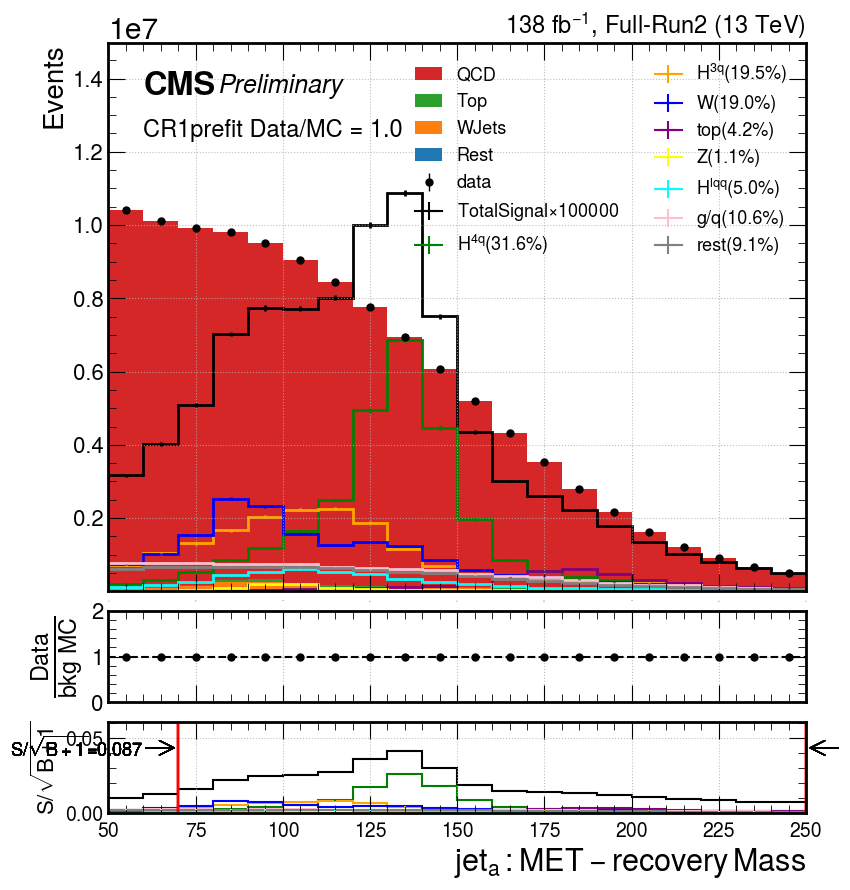

/tmp/ipykernel_910750/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_910750/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_910750/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_910750/2383463486.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_910750/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_910750/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_910750/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_910750/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_910750/314159992.p

Should scale signal *  44.58681513416486
Optimal two-side cut = 2 10 0.7300427787626256
Optimal one-side cut = 0 0.657373426157901
Optimal mid-side cut =  1 0.6113178286623054


/tmp/ipykernel_910750/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_910750/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_910750/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


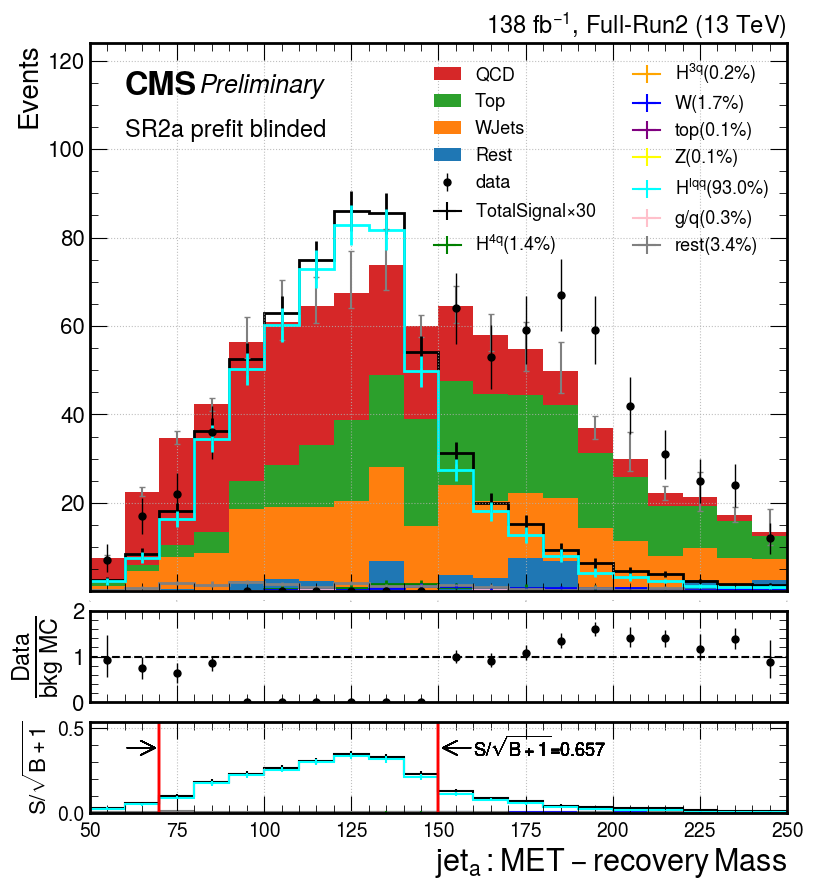

Should scale signal *  538.2911894437862
Optimal two-side cut = 2 20 0.239028594772351
Optimal one-side cut = 2 0.2390362535104071
Optimal mid-side cut =  3 0.1812292345724232


/tmp/ipykernel_910750/2383463486.py:110: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_910750/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_910750/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_910750/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_910750/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_910750/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_910750/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_910750/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_910750/314159992.p

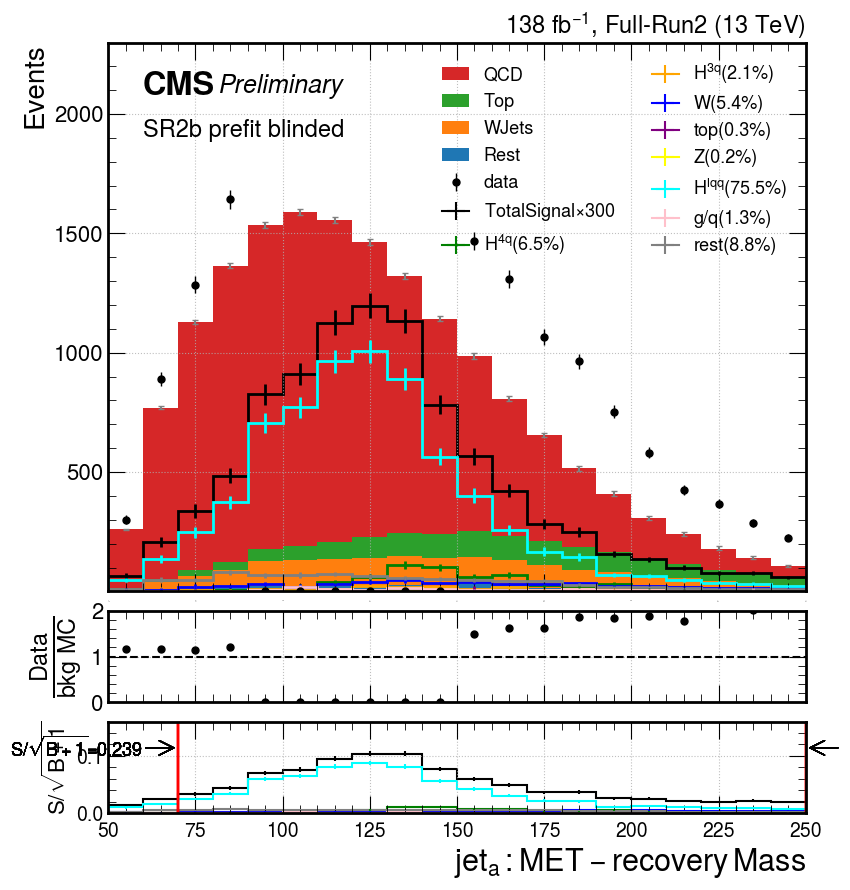

Should scale signal *  41385.8726086782
Optimal two-side cut = 3 20 0.05691321154984823
Optimal one-side cut = 3 0.05691321755364421
Optimal mid-side cut =  3 0.020259174839364475


/tmp/ipykernel_910750/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_910750/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_910750/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


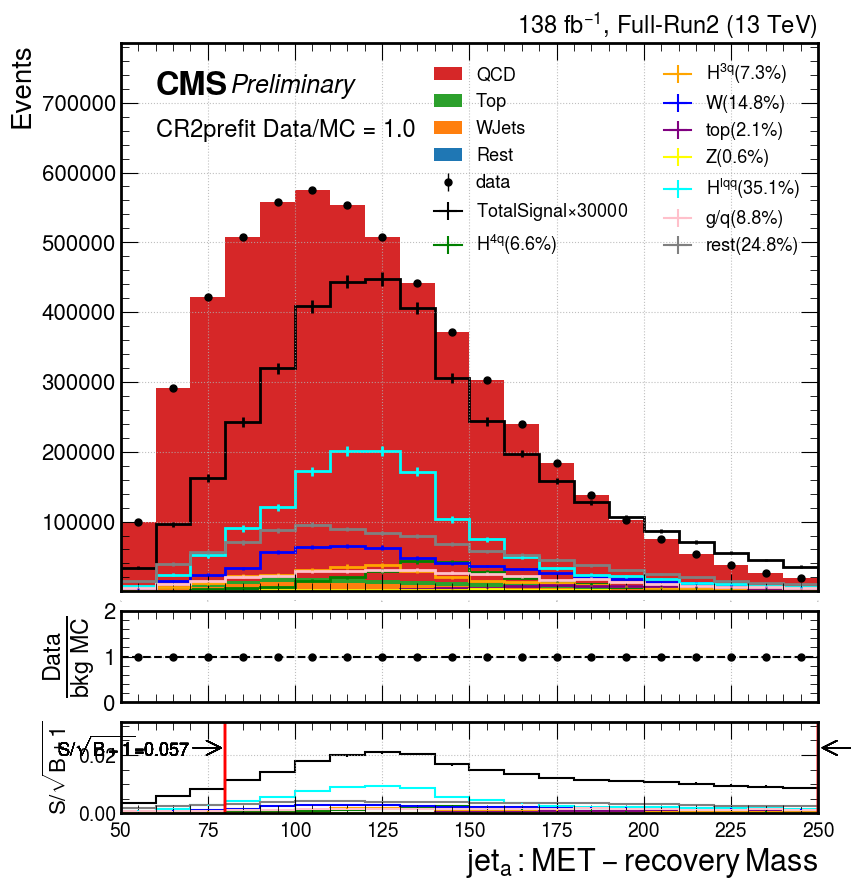

In [30]:
prefit_runPlots(region = "SR1a", blind = True, othertext = "prefit")
prefit_runPlots(region = "SR1b", blind = True, othertext = "prefit")
prefit_runPlots(region = "CR1",  blind = False, othertext = "prefit")
prefit_runPlots(region = "SR2a", blind = True, othertext = "prefit")
prefit_runPlots(region = "SR2b", blind = True, othertext = "prefit")
prefit_runPlots(region = "CR2",  blind = False, othertext = "prefit")